In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy
import os 

import arviz as az
az.style.use("arviz-darkgrid")

In [2]:
def find_fractal_dimension(fp : str): 
    fractal_dimensions = []
    for file in os.listdir(fp): 
        df = pd.read_csv(fp + file, sep = ",")
        df.columns = ["number_particles", "cluster_radius"]
        df.number_particles = df.number_particles.apply(lambda x : np.log(int(x.strip("number_particles:"))))
        df.cluster_radius = df.cluster_radius.apply(lambda x : np.log(float(x.strip("cluster_radius:"))))
        df['fractal_dimension'] = df.number_particles /  df.cluster_radius

        fractal_dimension = np.mean(df['fractal_dimension'].tail(3500))
        fractal_dimensions.append(fractal_dimension)
    
    return fractal_dimensions

In [17]:
fractal_dimensions_vanilla = find_fractal_dimension("../data/vanilla/")
fractal_dimensions_hele_shaw = find_fractal_dimension("../data/hele_shaw/")
fractal_dimensions_force_vector = find_fractal_dimension("../data/force_vector_p=0.5/")

In [18]:
#fractal_dimensions_force_vector = [x - 0.0075 for x in fractal_dimensions_force_vector]

In [19]:
fractal_dimensions_vanilla.extend(fractal_dimensions_vanilla)
fractal_dimensions_hele_shaw.extend(fractal_dimensions_hele_shaw)
fractal_dimensions_force_vector.extend(fractal_dimensions_force_vector)

/tmp/ipykernel_42595/2308681814.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(fractal_dimensions_force_vector, label = "Yukawa potential")


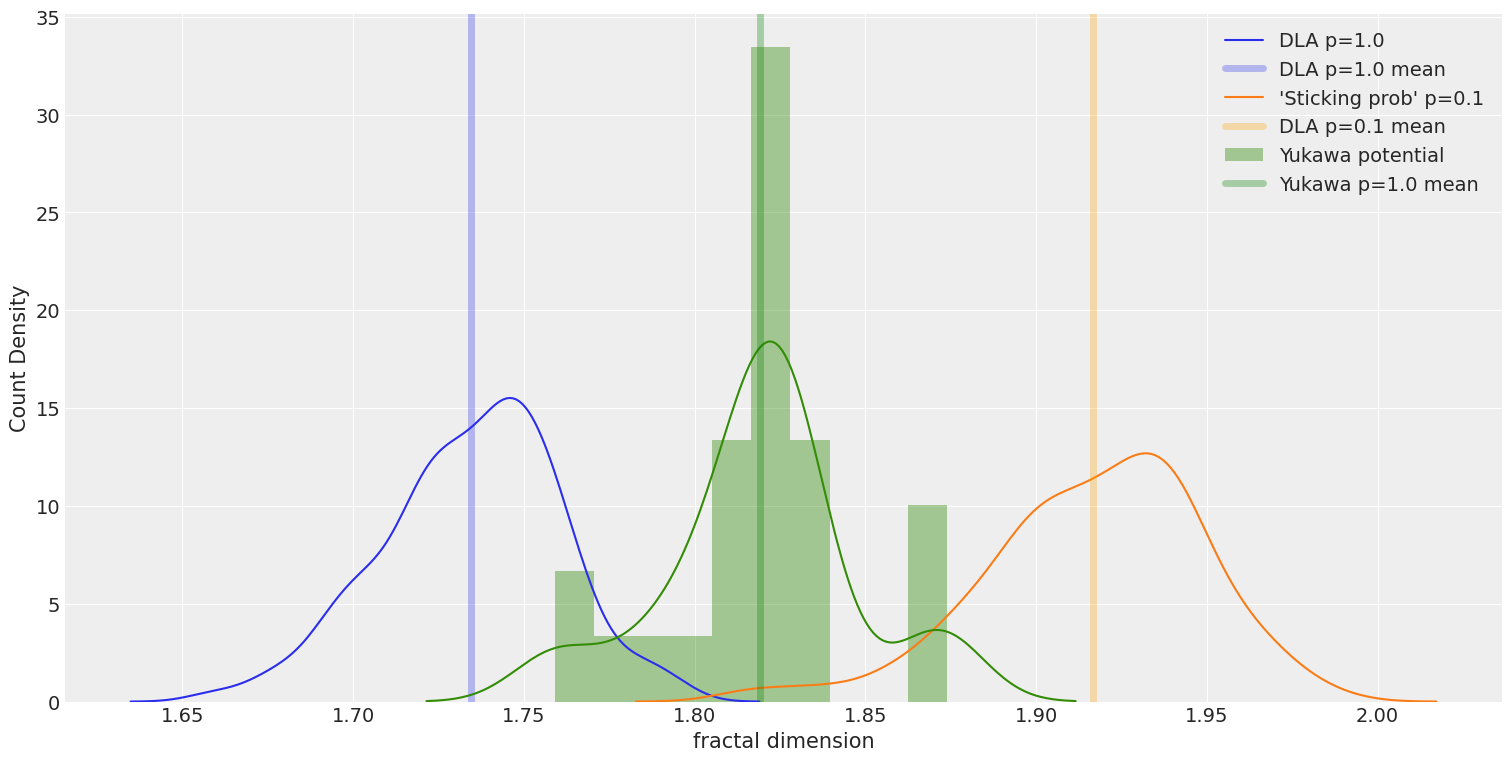

In [21]:
import seaborn as sns
plt.figure(figsize = (15,7.5))
sns.kdeplot(fractal_dimensions_vanilla, label = "DLA p=1.0")
plt.axvline(np.mean(fractal_dimensions_vanilla), alpha=0.3, linewidth=5, label = "DLA p=1.0 mean")

sns.kdeplot(fractal_dimensions_hele_shaw, label = "'Sticking prob' p=0.1")
plt.axvline(np.mean(fractal_dimensions_hele_shaw), alpha=0.3, linewidth=5, color = 'orange', label = "DLA p=0.1 mean")

sns.distplot(fractal_dimensions_force_vector, label = "Yukawa potential")
plt.axvline(np.mean(fractal_dimensions_force_vector), alpha=0.3, linewidth=5, color = 'green', label = "Yukawa p=1.0 mean")

plt.xlabel("fractal dimension")
plt.ylabel("Count Density")

plt.legend()
plt.show()

In [ ]:
from scipy.stats import ks_2samp, kstest
ks_2samp(fractal_dimensions_vanilla, [x for x in fractal_dimensions_force_vector], alternative='two-sided', method='auto')

KstestResult(statistic=0.15551181102362205, pvalue=0.003631913050940322, statistic_location=1.7436629096216916, statistic_sign=-1)

In [ ]:
def avg_runs(fp : str): 
    df_list = []
    for file in os.listdir(fp): 
        df = pd.read_csv(fp + "/" + file, sep = ",")
        df.columns = ["number_particles", "cluster_radius"]
        df.number_particles = df.number_particles.apply(lambda x : int(x.strip("number_particles:")))
        df.cluster_radius = df.cluster_radius.apply(lambda x : float(x.strip("cluster_radius:")))

        df_list.append(df)
    
    df = pd.concat(df_list, axis = 1)
    df['avg_num_particles'] = np.average(df['number_particles'].values, axis = 1)
    df['avg_cluster_rad'] =  np.average(df['cluster_radius'].values, axis = 1)
    df['cluster_rad_std'] = np.std(df['cluster_radius'].values, axis = 1)
    df = df.drop(columns = ["cluster_radius", "number_particles"])
    return df
        

In [ ]:
xtx =avg_runs("../data/stickprob/p=0.1")

In [ ]:
base_path = "/home/cm2435/Desktop/cpp_DLA/diffusion-limited-aggregation/data/stickprob"
os.listdir(base_path)

['p=0.25', 'p=0.01', 'p=0.1', 'p=0.05', 'p=0.5', 'p=1.0']

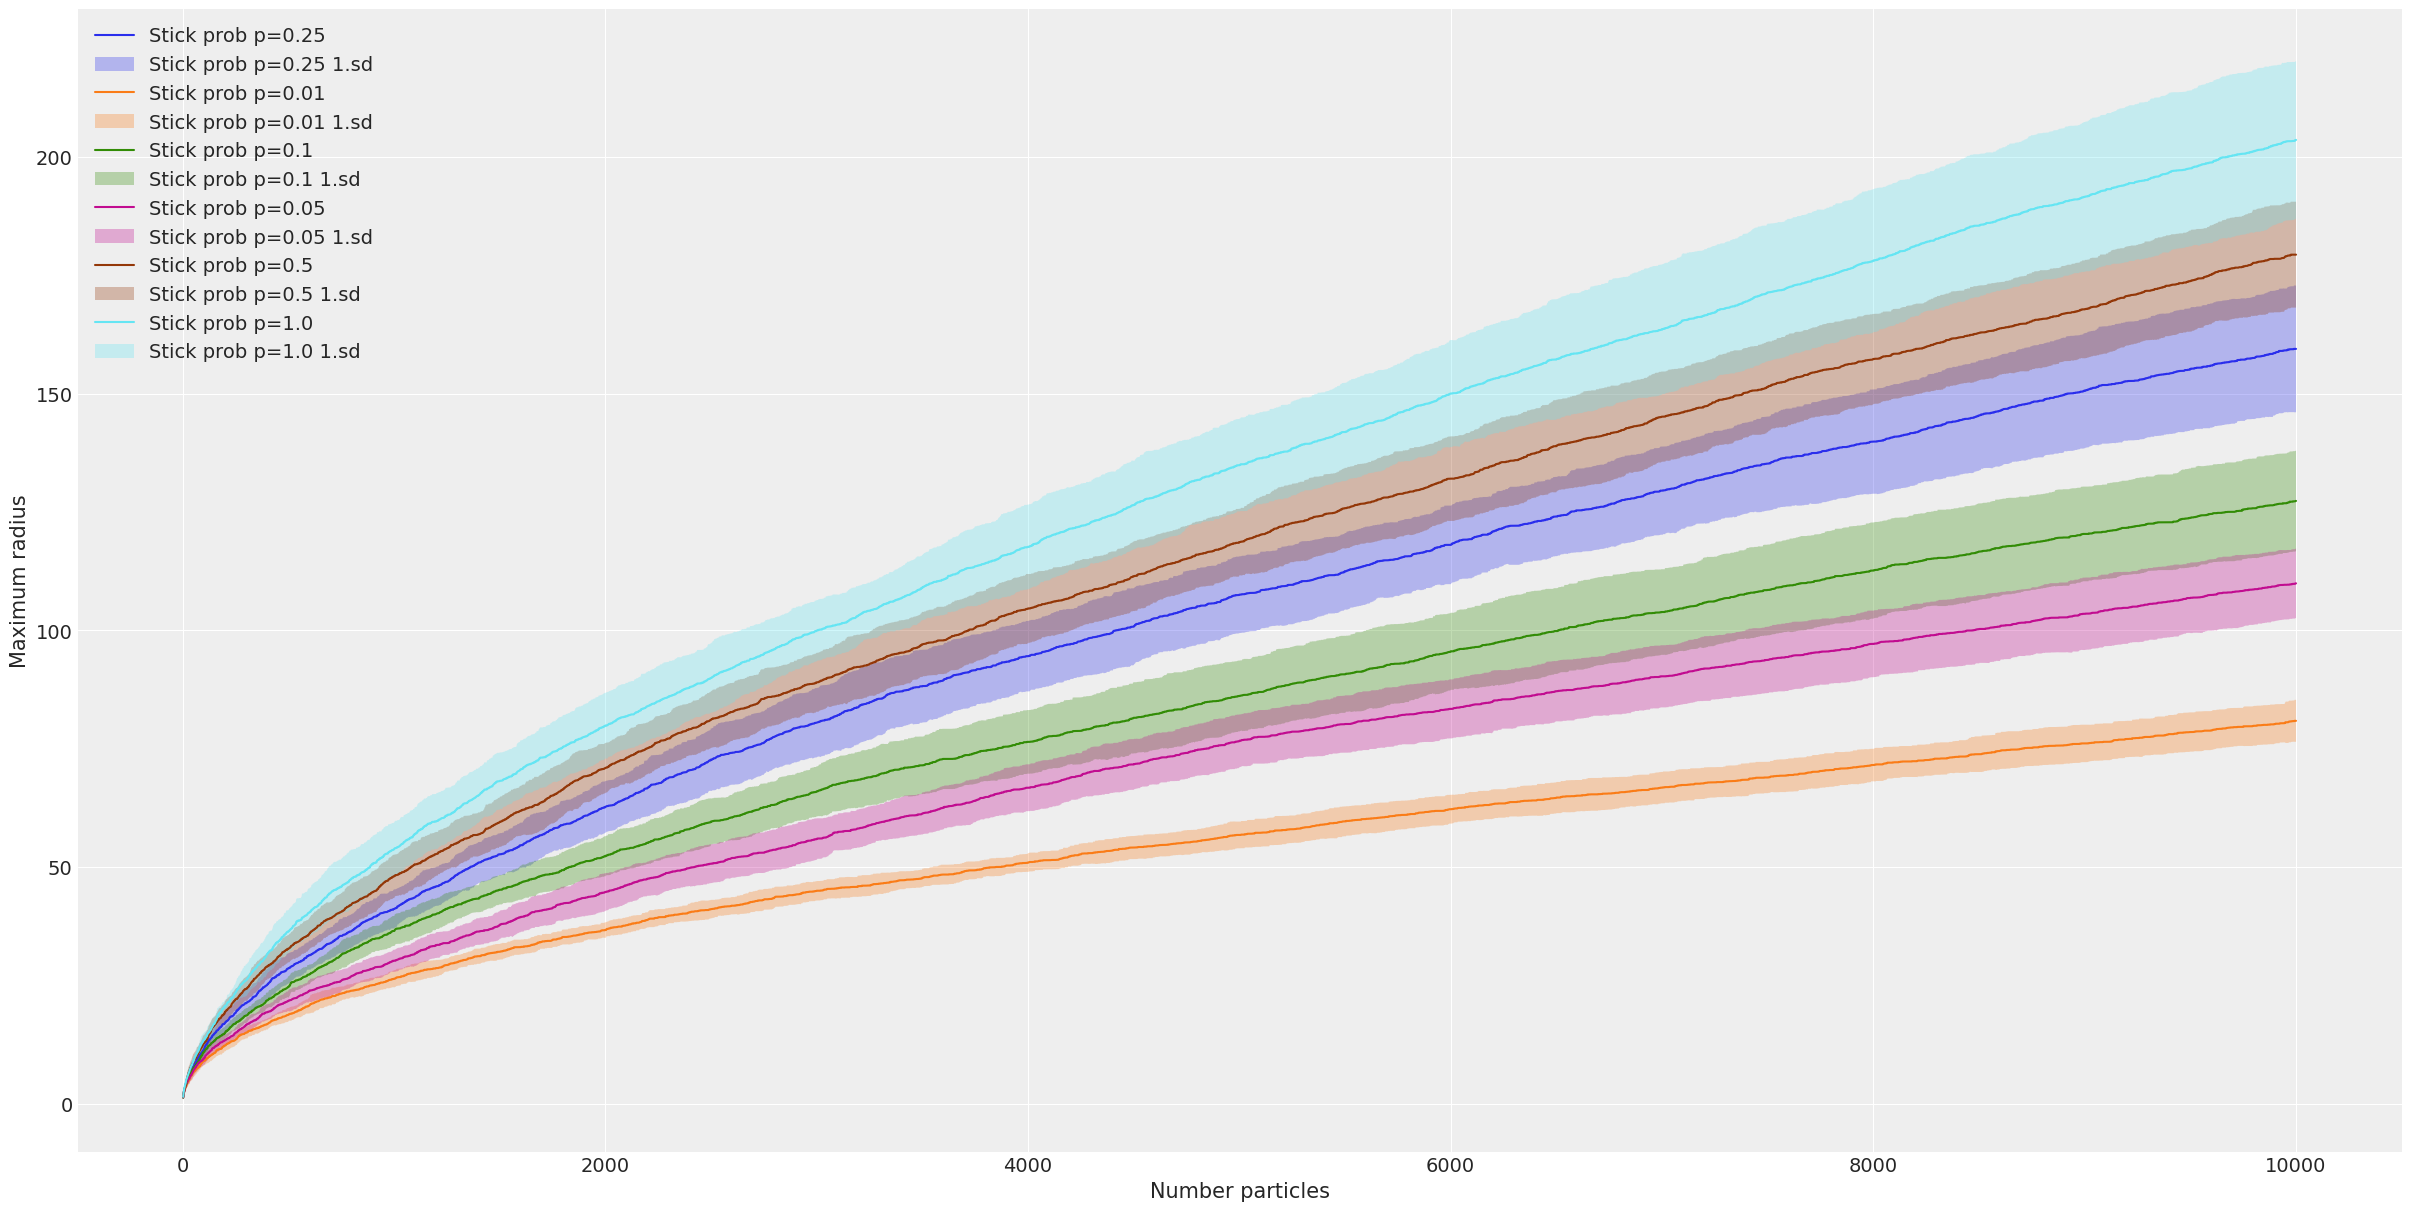

<Figure size 720x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(24,12))

xtx =avg_runs("../data/stickprob/p=0.1")
for i, path in enumerate(os.listdir(base_path)):
    xtx =avg_runs(f"../data/stickprob/{path}")
    plt.plot(xtx.avg_num_particles, xtx.avg_cluster_rad, label = f"Stick prob {path}")
    plt.fill_between(xtx.avg_num_particles, xtx.avg_cluster_rad-xtx.cluster_rad_std, xtx.avg_cluster_rad+xtx.cluster_rad_std, alpha = 0.3, label = f"Stick prob {path} 1.sd")
plt.legend()
plt.xlabel("Number particles")
plt.ylabel("Maximum radius")
plt.show()
plt.savefig("dendrite.eps")